In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import joblib

nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

In [ ]:
df = pd.read_csv('../data/olist_order_reviews_dataset.csv')
df = df[['review_score', 'review_comment_message', 'review_creation_date']].copy()
df.dropna(subset=['review_comment_message'], inplace=True)
df.head()

,review_score,review_comment_message,review_creation_date
3,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00
4,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00
9,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00
15,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00


In [5]:
def label_sentiment(score):
    if score >= 4:
        return 'positive'
    if score == 3:
        return 'neutral'
    else:
        return 'negative'
    
df['sentiment'] = df['review_score'].apply(label_sentiment)
df['sentiment'].value_counts(normalize=True)

sentiment
positive    0.647436
negative    0.265759
neutral     0.086805
Name: proportion, dtype: float64

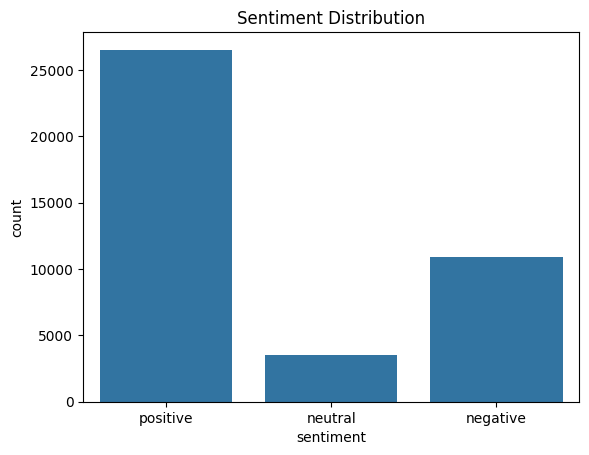

In [7]:
sns.countplot(x='sentiment', data=df, order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution')
plt.show()

# Preprocessing

In [8]:
stop_words = set(stopwords.words('portuguese'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-záéíóúãõç\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_message'] = df['review_comment_message'].apply(clean_text)
df.head()

,review_score,review_comment_message,review_creation_date,sentiment,cleaned_message
3,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,positive,recebi bem antes prazo estipulado
4,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,positive,parabéns lojas lannister adorei comprar intern...
9,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,positive,aparelho eficiente site marca aparelho impress...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,positive,pouco travandopelo valor ta boa
15,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,positive,vendedor confiável produto ok entrega antes prazo


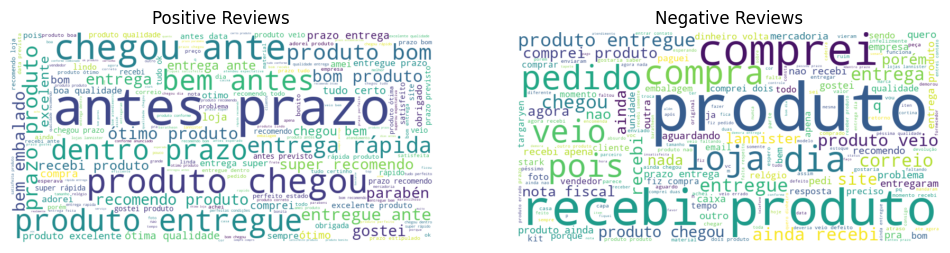

In [11]:
# wordcloud positive and negative sentiment

positive = ' '.join(df[df['sentiment'] == 'positive']['cleaned_message'])
negative = ' '.join(df[df['sentiment'] == 'negative']['cleaned_message'])

wc = WordCloud(background_color='white', width=800, height=400)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wc.generate(positive), interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews")

plt.subplot(1,2,2)
plt.imshow(wc.generate(negative), interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews")
plt.show()

In [12]:
df.to_csv('../data/olist_reviews_cleaned.csv', index=False)

# Feature Engineering

In [13]:
df = df[df['sentiment'] != 'neutral']
df['label'] = df['sentiment'].map({'positive':1, 'negative':0})
df.head()

,review_score,review_comment_message,review_creation_date,sentiment,cleaned_message,label
3,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,positive,recebi bem antes prazo estipulado,1
4,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,positive,parabéns lojas lannister adorei comprar intern...,1
9,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,positive,aparelho eficiente site marca aparelho impress...,1
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,positive,pouco travandopelo valor ta boa,1
15,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,positive,vendedor confiável produto ok entrega antes prazo,1


In [15]:
X = df['cleaned_message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [16]:
#TF-IDF Vectorization

vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Modeling

In [19]:
# Logistic Regression

lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

print("Logistic Regression Report: \n", classification_report(y_test, y_pred_lr))

Logistic Regression Report: 
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      2178
           1       0.94      0.94      0.94      5306

    accuracy                           0.92      7484
   macro avg       0.90      0.90      0.90      7484
weighted avg       0.92      0.92      0.92      7484



In [20]:
# Random Forest

rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
y_pred_rf = lr.predict(X_test_tfidf)

print("Random Forest Report: \n", classification_report(y_test, y_pred_rf))

Random Forest Report: 
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      2178
           1       0.94      0.94      0.94      5306

    accuracy                           0.92      7484
   macro avg       0.90      0.90      0.90      7484
weighted avg       0.92      0.92      0.92      7484



In [21]:
joblib.dump(vectorizer, '../src/tfidf_vectorizer.pkl')
joblib.dump(lr, '../src/sentiment_model.pkl')

['../src/sentiment_model.pkl']